### Generating human faces with Adversarial Networks
<img src="images/nvidia_cool_gan.png" width="400px"/>
© research.nvidia.com_

This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on https://github.com/Lasagne/Recipes/pull/94 .


In [1]:
# %%bash

# shred -u setup_colab.py

# wget https://raw.githubusercontent.com/hse-aml/intro-to-dl-pytorch/main/utils/setup_colab.py -O setup_colab.py

In [2]:
import setup_colab
# 
setup_colab.setup_week04()

In [3]:
# import download_utils

# download_utils.download_week_4_resources('.')

In [4]:
import grading

grader = grading.Grader(
    assignment_key="FCl7G51lEeeeZQ4xJ2nzLA",
    all_parts=["ryO01"]
)

In [5]:
# token expires every 30 min
COURSERA_TOKEN = "obUWpcQR4gtDrSlD"
COURSERA_EMAIL = "pavelb23@gmail.com"

In [6]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

In [7]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
# The following line fetches you two datasets:
# images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles),
# so please keep them in mind
from lfw_dataset import load_lfw_dataset 
data, attrs = load_lfw_dataset(dimx=36, dimy=36)

# preprocess faces
data = np.float32(data) / 255.

data = torch.from_numpy(data).permute(0, 3, 1, 2)

min_data = data.min()
max_data = data.max()

IMG_SHAPE = data.shape[1:]

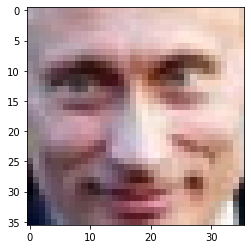

In [8]:
# print random image
plt.imshow(data[np.random.randint(data.shape[0])].permute(1, 2, 0),
           cmap="gray", interpolation="none")

# Generative adversarial nets 101

<img src="images/noise_to_face.png" width="400px"/>
_© torch.github.io_

Deep learning is simple, isn't it? 
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [9]:
import torch, torch.nn as nn
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

Torch version: 1.9.1
Using GPU


In [10]:
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.cuda() if use_cuda else noise.cpu()
    
class Reshape(nn.Module):
    
    def __init__(self, shape):
        super().__init__()
        
        self.shape = shape
        
    def forward(self, input):
        return input.view(self.shape)

In [11]:
CODE_SIZE = 256

from itertools import count
# automatic layer name maker. Don't do this in production :)
ix = ('layer_%i'%i for i in count())

def make_generator():
    generator = nn.Sequential()

    generator.add_module(next(ix), nn.Linear(CODE_SIZE, 10 * 8 *8))
    generator.add_module(next(ix), nn.ELU())
    generator.add_module(next(ix), Reshape([-1, 10, 8, 8]))

    generator.add_module(next(ix), nn.ConvTranspose2d(10, 64, kernel_size=(5, 5)))
    generator.add_module(next(ix), nn.ELU())
    generator.add_module(next(ix), nn.ConvTranspose2d(64, 64, kernel_size=(5, 5)))
    generator.add_module(next(ix), nn.ELU())
    generator.add_module(next(ix), nn.Upsample(scale_factor=2))

    generator.add_module(next(ix), nn.ConvTranspose2d(64, 32, kernel_size=(5, 5)))
    generator.add_module(next(ix), nn.ELU())
    generator.add_module(next(ix), nn.ConvTranspose2d(32, 32, kernel_size=(5, 5)))
    generator.add_module(next(ix), nn.ELU())

    generator.add_module(next(ix), nn.Conv2d(32, 3, kernel_size=(5, 5)))

    return generator

generator = make_generator()

if use_cuda:
    generator = generator.cuda()

In [12]:
generated_data = generator(sample_noise_batch(5))
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, \
    "generator must output an image of shape %s, but instead it produces %s" % (IMG_SHAPE, generated_data.shape)

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [13]:
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(data.shape[0]), size=batch_size)
    batch = torch.tensor(data[idxs], dtype=torch.float32)
    return batch.cuda() if use_cuda else batch.cpu()

In [14]:
IMG_SHAPE

torch.Size([3, 36, 36])

In [15]:
import torchsummary

In [16]:

m=nn.Sequential(nn.Conv2d(3, 20, 3, padding=1),
                                 nn.LeakyReLU(0.1), 
                                 nn.AvgPool2d(2),
                                 nn.Conv2d(20, 40, 3,padding=1),
                                 nn.LeakyReLU(0.1),
                                 nn.AvgPool2d(2),
                                 nn.Conv2d(40, 80, 3,padding=1),
                                 nn.LeakyReLU(0.1),
                                 nn.AvgPool2d(2),
                                 nn.Flatten(),
                                ).to('cuda')
torchsummary.summary(m, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 32, 32]             560
         LeakyReLU-2           [-1, 20, 32, 32]               0
         AvgPool2d-3           [-1, 20, 16, 16]               0
            Conv2d-4           [-1, 40, 16, 16]           7,240
         LeakyReLU-5           [-1, 40, 16, 16]               0
         AvgPool2d-6             [-1, 40, 8, 8]               0
            Conv2d-7             [-1, 80, 8, 8]          28,880
         LeakyReLU-8             [-1, 80, 8, 8]               0
         AvgPool2d-9             [-1, 80, 4, 4]               0
          Flatten-10                 [-1, 1280]               0
Total params: 36,680
Trainable params: 36,680
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.62
Params size (MB): 0.14
Estimated Tot

In [17]:
# Create convolutional architecture for discriminator
# Note: please start simple. A few convolutions & poolings would do, inception/resnet is an overkill

# YOUR CODE HERE
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.inner=nn.Sequential(nn.Conv2d(3, 20, 3, padding=1),
                                 nn.LeakyReLU(0.1), 
                                 nn.AvgPool2d(2),
                                 nn.Dropout2d(p=0.2),
                                 nn.Conv2d(20, 40, 3,padding=1),
                                 nn.ELU(),
                                 nn.AvgPool2d(2),
                                 nn.Conv2d(40, 80, 3,padding=1),
                                 nn.Dropout2d(p=0.2),
                                 nn.ELU(),
                                 nn.AvgPool2d(2),
                                 nn.Flatten(),
                                 nn.Linear(1280, 500),
                                 nn.ELU(),
                                 nn.Linear(500, 100),
                                 nn.ELU(),
                                 nn.Linear(100, 20),
                                 nn.ELU(),
                                 nn.Linear(20, 1),
                                )
    
    def forward(self, X):
        x=self.inner(X)
        return x
        

discriminator = Discriminator()

ans = len(discriminator(torch.rand(1, *IMG_SHAPE)))

if use_cuda: 
    discriminator = discriminator.cuda()

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

<img src="images/gan.png" width="600px"/>
_© deeplearning4j.org_

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [18]:
loss_f=nn.BCELoss()

In [19]:
def generator_loss(noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    
    gen_img=generator(noise)
    # print(gen_img.shape)
    disc_output= discriminator(gen_img)
    # print(disc_output.shape)
    # labels=torch.zeros(disc_output.shape, device='cuda')
    labels=torch.ones(disc_output.shape, device='cuda')
    
    loss=loss_f(torch.sigmoid(disc_output), labels)
    
    return loss.reshape(-1)
    # return 1
    
    # YOUR CODE HERE

In [20]:
loss = generator_loss(sample_noise_batch(32))

print(loss)

assert len(loss.shape) == 1 and loss.shape[0] == 1, "loss must be scalar"

tensor([0.6982], device='cuda:0', grad_fn=<ViewBackward>)


In [21]:
def discriminator_loss(real_data, generated_data):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """
    
    disc_output_real=discriminator(real_data)
    real_label=torch.ones(disc_output_real.shape, device='cuda')
    real_loss=loss_f(torch.sigmoid(disc_output_real), real_label).reshape(-1)
    # real_loss=loss_f( F.logsigmoid(disc_output_real, real_label).reshape(-1)
    
    gen_output=discriminator(generated_data)
    gen_label=torch.zeros(gen_output.shape, device='cuda')
    gen_loss=loss_f(torch.sigmoid(gen_output), gen_label).reshape(-1)
    # gen_loss=loss_f(gen_output, gen_label).reshape(-1)
    return real_loss + gen_loss
    # return real_loss + gen_loss
    # YOUR CODE HERE

In [22]:
loss = discriminator_loss(
    sample_data_batch(32),
    generator(sample_noise_batch(32))
)

print(loss)

assert len(loss.shape) == 1 and loss.shape[0] == 1, "loss must be scalar"

tensor([1.3840], device='cuda:0', grad_fn=<AddBackward0>)


/tmp/ipykernel_27594/1793902344.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(data[idxs], dtype=torch.float32)


### Auxiliary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [23]:
def sample_images(nrow, ncol, sharp=False):
    images = generator(sample_noise_batch(batch_size=nrow * ncol))
    images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    
    if np.var(images) != 0:
        images = images.clip(min_data, max_data)
        
    for i in range(nrow * ncol):
        plt.subplot(nrow, ncol, i + 1)
        if sharp:
            plt.imshow(images[i], cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i], cmap="gray")
    
    plt.show()

def sample_probas(batch_size, epoch=0):
    plt.title(f'Generated vs real data for epoch={epoch}')
    D_real = torch.sigmoid(discriminator(sample_data_batch(batch_size)))
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = torch.sigmoid(discriminator(generated_data_batch))
    
    plt.hist(D_real.data.cpu().numpy(),
             label='D(x)', alpha=0.5, range=[0, 1])
    plt.hist(D_fake.data.cpu().numpy(),
             label='D(G(z))', alpha=0.5, range=[0, 1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and plot results once every N iterations.

In [24]:
#optimizers
discriminator = Discriminator()
generator = make_generator()

if use_cuda:
    discriminator = discriminator.cuda()
    generator = generator.cuda()

disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.4, 0.999))
# disc_opt = torch.optim.SGD(discriminator.parameters(), lr=0.0004)
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.7, 0.999))

lr_scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer=disc_opt,
    milestones=list(range(10000,500000, 10000)),
    gamma=0.3,
    verbose=False
)

disc loss 1.3746058940887451
gen loss 0.7040397524833679


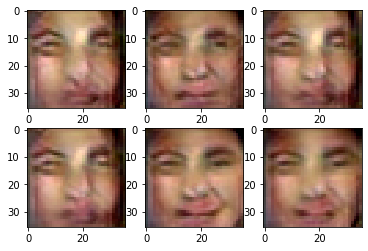

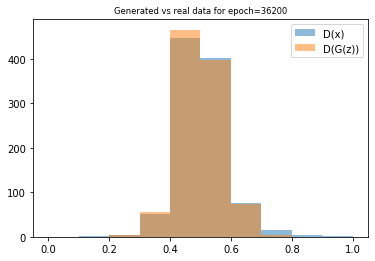

KeyboardInterrupt: 

In [25]:
from IPython import display
from tqdm import tnrange
batch_size = 100

for epoch in tnrange(50000):
    
    # Train discriminator
    for i in range(5):
        discriminator.zero_grad()
        real_data = sample_data_batch(batch_size)
        fake_data = generator(sample_noise_batch(batch_size))
        
        loss_disc=discriminator_loss(real_data, fake_data)
        disc_opt.zero_grad()
        loss_disc.backward()
        disc_opt.step()
        
        
    # Train generator
    noise = sample_noise_batch(batch_size)
    loss = generator_loss(noise)
    gen_opt.zero_grad()
    loss.backward()
    gen_opt.step()
    lr_scheduler.step()
    
    if epoch % 100 == 0:
        display.clear_output(wait=True)
        print(f'disc loss {loss_disc.item()}')
        print(f'gen loss {loss.item()}')
        sample_images(2, 3, True)
        sample_probas(1000, epoch=epoch)

In [ ]:
#The network was trained for about 15k iterations.
#Training for longer yields MUCH better results
plt.figure(figsize=[16, 24])
sample_images(16, 8)

# Submit to Coursera

In [ ]:
## GRADED PART, DO NOT CHANGE!
# grader.set_answer("ryO01", ans)

In [ ]:
# grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)